In [7]:
#imports 
import sys
import random
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt

In [9]:
# Helper functions

AA = list("ACDEFGHIKLMNPQRSTVWY")

# returns the spike protein from the FASTA as a string
def load_spike(fasta_path):
    """Read FASTA and return sequence string."""
    seq = []
    with open(fasta_path) as f:
        for line in f:
            if line.startswith(">"):
                continue
            seq.append(line.strip())
    return "".join(seq)

# mutates sequence by picking k mutations using binomial, and mutating the k muts in random positions to any of the 19 AAs
def mutate_sequence(seq, mu): 
    n = len(seq)
    # pick num mutations with probability of mutating mu 
    k = np.random.binomial(n, mu)
    if k == 0:
        return seq  # no change

    seq_list = list(seq)
    # pick k distinct positions
    for pos in random.sample(range(n), k):
        orig = seq_list[pos]
        # choose replacement all amino acids are equally likely 
        choices = [a for a in AA if a != orig]
        seq_list[pos] = random.choice(choices)

    return "".join(seq_list)




In [11]:
def run_mc(spike_seq, epitope_set, num_trials, mu):
    # Pre-compute W = all known epitopes already in WT Spike
    wt_9mers = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)}
    W = wt_9mers & epitope_set            # set of baseline (WT-present) epitopes


    gain_trials = 0                       # how many trials gained ≥1 new epitope (more susceptible) 
    loss_trials = 0                       # how many trials lost ≥1 WT epitope (less susceptible) 
    net_changes = []                      # list of (#gained − #lost) for every trial
    gains = []
    losses = []

    # Monte Carlo 
    for count in range(num_trials):
        mutated = mutate_sequence(spike_seq, mu)        # mutate once
        mut_9mers = {mutated[i:i+9] for i in range(len(mutated) - 8)}
        hits = mut_9mers & epitope_set                  # all known epitopes in this mutant

        gained = hits - W                               # new epitopes not in WT
        lost   = W - hits                               # WT epitopes that disappeared

        if gained:                                      # flag “gain” trial
            gain_trials += 1
        if lost:                                        # flag “loss” trial
            loss_trials += 1
        gains.append(len(gained))
        losses.append(len(lost))
        net_changes.append(len(gained) - len(lost))     # could be pos, zero, or neg

    # Find Stats
    p_gain  = gain_trials / num_trials
    p_loss  = loss_trials / num_trials
    mean_nc = np.mean(net_changes)                      # mean net change

    return p_gain, p_loss, mean_nc, net_changes, gains, losses


def first_hit_cycles(spike_seq, epitope_set, mu, want_gain=True, max_cycles=100000):
    """
    Simulate mutation cycles until EITHER
        • at least one new epitope appears   (want_gain=True)   OR
        • at least one WT epitope disappears (want_gain=False)

    Returns the number of cycles required.  Stops after `max_cycles`
    """
    W = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)} & epitope_set
    seq = spike_seq
    for cycle in range(1, max_cycles + 1):
        seq = mutate_sequence(seq, mu)
        mut_9mers = {seq[i:i+9] for i in range(len(seq) - 8)}
        hits = mut_9mers & epitope_set

        gained = hits - W
        lost   = W - hits

        if  (want_gain and gained) or (not want_gain and lost):
            return cycle          
    return max_cycles              

def first_hit_cycles_net(spike_seq, epitope_set, mu, want_gain=True, max_cycles=100000):
    """
    Simulate mutation cycles until EITHER
        • at least one new epitope appears   (want_gain=True)   OR
        • at least one WT epitope disappears (want_gain=False)

    Returns the number of cycles required.  Stops after `max_cycles`
    """
    W = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)} & epitope_set
    seq = spike_seq
    for cycle in range(1, max_cycles + 1):
        seq = mutate_sequence(seq, mu)
        mut_9mers = {seq[i:i+9] for i in range(len(seq) - 8)}
        hits = mut_9mers & epitope_set

        gained = hits - W
        lost   = W - hits

        net = len(gained) - len(lost)
        if (want_gain and net > 0) or (not want_gain and net < 0):
            return cycle         
    return max_cycles    


def run_experiments(spike_seq, epitope_set, mu, n_exp=100):
    cycles_to_gain = []
    cycles_to_loss = []

    for count in range(n_exp):
        cycles_to_gain.append(
            first_hit_cycles(spike_seq, epitope_set, mu, want_gain=True)
        )
        cycles_to_loss.append(
            first_hit_cycles(spike_seq, epitope_set, mu, want_gain=False)
        )

    return cycles_to_gain, cycles_to_loss


def run_experiments_net(spike_seq, epitope_set, mu, n_exp=100):
    cycles_to_gain = []
    cycles_to_loss = []

    for count in range(n_exp):
        cycles_to_gain.append(
            first_hit_cycles_net(spike_seq, epitope_set, mu, want_gain=True)
        )
        cycles_to_loss.append(
            first_hit_cycles_net(spike_seq, epitope_set, mu, want_gain=False)
        )

    return cycles_to_gain, cycles_to_loss


def plot_cycles(cycles, title):
    plt.figure(figsize=(10,4))
    plt.plot(range(1, len(cycles)+1), cycles, lw=0.8)
    plt.xlabel("Experiment #")
    plt.ylabel("Cycles needed")
    plt.title(title)
    plt.tight_layout()

In [13]:

path = '/Users/adityakoushik/Downloads/epitope_table_export_1748931548.csv'
df = pd.read_csv(path)
df = df[['Epitope - Name']]
mask = df["Epitope - Name"].str.len() == 9
epitope_set = set(df.loc[mask, "Epitope - Name"].tolist())


In [15]:
# Adjust these paths as needed:
spike_fasta_path = "/Users/adityakoushik/Desktop/spike.fasta"


# Monte Carlo parameters:
N = 100000        # number of trials
mu = 1e-5         # per-site mutation rate


spike_seq = load_spike(spike_fasta_path)
print(f"Loaded spike (length {len(spike_seq)} aa), {len(epitope_set)} epitopes.")
# EXPECTATION for NUMER OF MUTS 
print("Expected Number of Mutations in one trial: %s" %(len(spike_seq) * mu))

p_gain, p_loss, mean_nc, net_changes, gains, losses = run_mc(spike_seq, epitope_set, N, mu)

print("Results:")
print(f"  Prob of gaining epitope: {p_gain}")
print(f"  Prob of losing epitope: {p_loss}")
print(f"  Mean num epitopes gained: {mean_nc}")



Loaded spike (length 1273 aa), 4222 epitopes.
Expected Number of Mutations in one trial: 0.012730000000000002
Results:
  Prob of gaining epitope: 2e-05
  Prob of losing epitope: 0.00996
  Mean num epitopes gained: -0.02111


In [17]:
 W = {spike_seq[i:i+9] for i in range(len(spike_seq) - 8)} & epitope_set

In [19]:
epitope_set - W


{'HSKKKCDEF',
 'RKKARSTPF',
 'SHDVLTVQF',
 'KLVCSPAPC',
 'ALYDVVSKL',
 'GLYKSAPRR',
 'KAKGSRAIW',
 'LLDTASALY',
 'SSWEDVPYL',
 'ARYAYYLQF',
 'GLGTLGAAL',
 'SAINNFCQK',
 'LPFERATVL',
 'HERLDEFEL',
 'QLISAVNKL',
 'TAVDFGNSY',
 'SQRQKKVTF',
 'LPPVVAKEI',
 'TPEAKNSTF',
 'LLCPTGHAV',
 'YFHALVYFV',
 'NLSDRVVFV',
 'RAEAQLHAW',
 'SVYGDTLEK',
 'GLVEVEKGV',
 'ILYGLGYSV',
 'IVIDEILFK',
 'LLMPILTLT',
 'DISEMGANF',
 'APENAYQAY',
 'FRKDVNMVL',
 'CLIRLKPTL',
 'DELVDPINY',
 'HFYWFFSNY',
 'ILSPFMPLL',
 'DEGLGWAGW',
 'FIAFLRFLA',
 'SFHNLHLLF',
 'SLFNAVAVL',
 'TQMNLKYAI',
 'NIADYNYKL',
 'REVRTIKVF',
 'ESKPSVEQR',
 'FYYVWKSYV',
 'YFIKGLNNL',
 'VRNLQHRLY',
 'QLFTFSPRR',
 'TSAFVFPTK',
 'VLYQDFDEM',
 'LPSYAALAT',
 'YQLAVTIMA',
 'RTQSPRRRR',
 'TYQWVMKNL',
 'KEWAYCVEM',
 'ALSEGVYRI',
 'VYMSPFYGY',
 'KLGGALQAK',
 'SLYNTVVTL',
 'IPTVMAFHL',
 'MSALNHTKK',
 'WKEPDVYYT',
 'LLLAVAVYA',
 'KPVPEVKIL',
 'FLYALALLL',
 'GMLICLTVL',
 'YPRPPGSGL',
 'RPDYNPPLL',
 'SDNEIHNPA',
 'SFLLSHGLI',
 'HLAAQGMAY',
 'YLESFCEDV',
 'CTEL

In [21]:
freq = pd.Series(net_changes).value_counts(sort=False)
freq1 = pd.Series(gains).value_counts(sort=False)
freq2 = pd.Series(losses).value_counts(sort=False)
print(freq)
print(freq1)
print(freq2)

 0     99004
-2       365
-1       354
-4        65
-3       167
-6         5
-5        27
-8         3
-7         7
-9         2
-10        1
dtype: int64
0    99998
1        2
dtype: int64
0     99004
2       365
1       353
4        65
3       168
6         5
5        27
8         3
7         7
9         2
10        1
dtype: int64


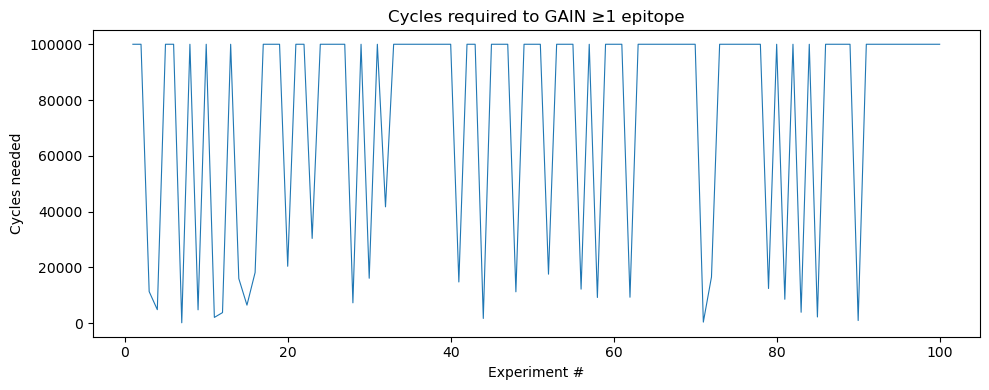

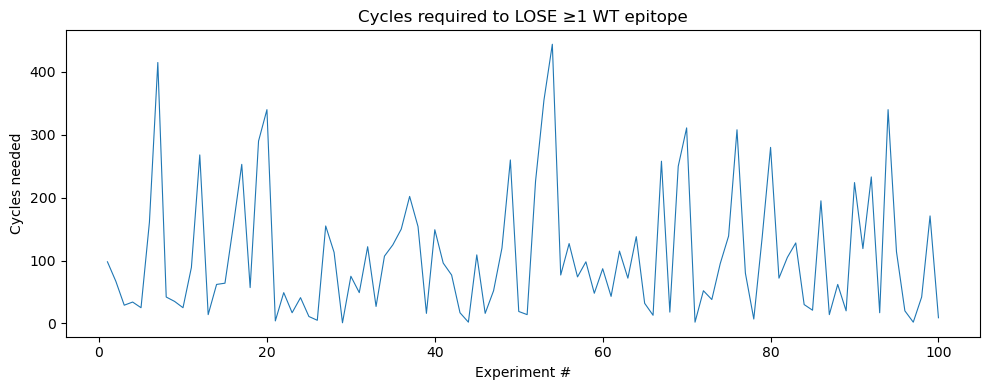

CPU times: user 19min 42s, sys: 12 s, total: 19min 54s
Wall time: 20min 21s


In [25]:
%%time
# Model as EXPONENTIAL/GEOMETRIC
# We dont look at net gain/loss, we just treat gaining an epitope and losing an epitope as seperate events 

cycles_gain, cycles_loss = run_experiments(spike_seq, epitope_set, mu)
plot_cycles(cycles_gain,  "Cycles required to GAIN ≥1 epitope")
plot_cycles(cycles_loss,  "Cycles required to LOSE ≥1 WT epitope")
plt.show()


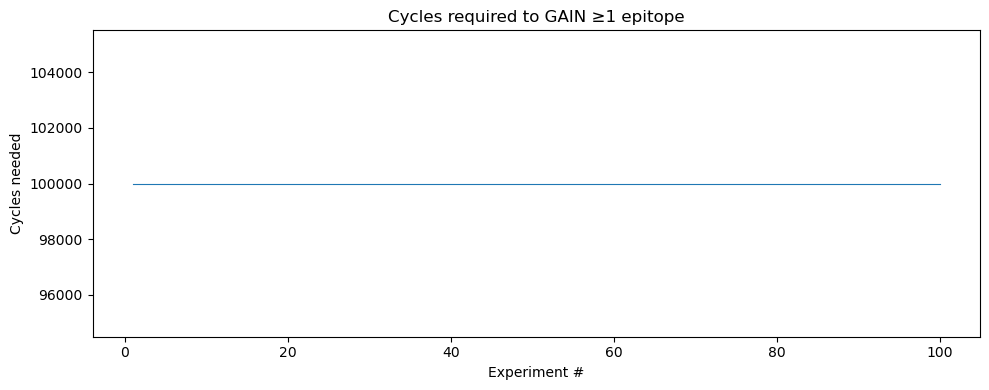

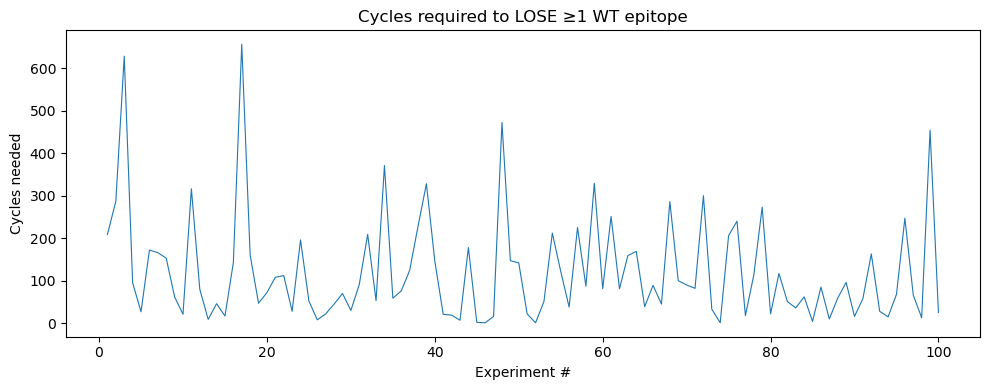

CPU times: user 26min 14s, sys: 27.6 s, total: 26min 42s
Wall time: 27min 4s


In [27]:
%%time
# Model as EXPONENTIAL/GEOMETRIC
# We dont look at net gain/loss, we just treat gaining an epitope and losing an epitope as seperate events 

cycles_gain, cycles_loss = run_experiments_net(spike_seq, epitope_set, mu)
plot_cycles(cycles_gain,  "Cycles required to GAIN ≥1 epitope")
plot_cycles(cycles_loss,  "Cycles required to LOSE ≥1 WT epitope")
plt.show()


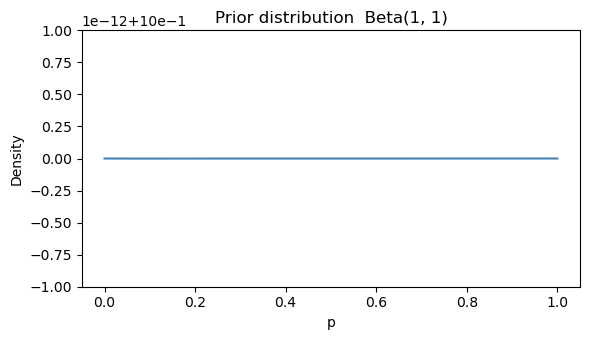

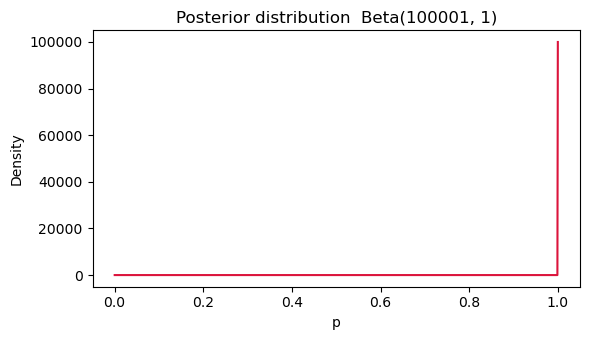

In [29]:
# 0.78 is meaningless and is the context of running thousands of simulations first 


# Replace with your real numbers
gain_trials = np.mean(cycles_gain) 


# 1. prior parameters  (uniform Beta(1,1))
alpha_prior, beta_prior = 1, 1

# 2. posterior parameters after observing g successes in N trials
alpha_post = alpha_prior + gain_trials
beta_post  = beta_prior  + N - gain_trials

# 3. x-axis grid (stretch enough to see the posterior bump)
post_mean = alpha_post / (alpha_post + beta_post)
x = np.linspace(0, 1, 1000)

# ----------------  Figure 1: prior  ----------------
fig1, ax1 = plt.subplots(figsize=(6, 3.5))
ax1.plot(x, beta.pdf(x, alpha_prior, beta_prior), color="steelblue")
ax1.set_xlabel("p")
ax1.set_ylabel("Density")
ax1.set_title("Prior distribution  Beta(1, 1)")
plt.tight_layout()

# ----------------  Figure 2: posterior  ------------
fig2, ax2 = plt.subplots(figsize=(6, 3.5))
ax2.plot(x, beta.pdf(x, alpha_post, beta_post), color="crimson")
ax2.set_xlabel("p")
ax2.set_ylabel("Density")
ax2.set_title(f"Posterior distribution  Beta({alpha_post:.0f}, {beta_post:.0f})")
plt.tight_layout()

plt.show()


In [ ]:
# MESS AROUND WITH MUtation rate  - look into origin of it

In [186]:
N

100000

In [196]:
cycles_gain

[100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 4608,
 100000,
 1229,
 4596,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 2708,
 6247,
 100000,
 28372,
 100000,
 100000,
 100000,
 100000,
 100000,
 77727,
 100000,
 100000,
 100000,
 4568,
 100000,
 100000,
 20412,
 100000,
 100000,
 100000,
 180,
 100000,
 100000,
 2155,
 12258,
 9983,
 100000,
 100000,
 100000,
 30704,
 100000,
 14872,
 100000,
 100000,
 100000,
 100000,
 9464,
 100000,
 100000,
 1261,
 100000,
 100000,
 100000,
 1092,
 8513,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 12953,
 8701,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 21691,
 100000,
 100000,
 100000,
 100000,
 9551,
 100000,
 100000,
 100000,
 100000,
 100000,
 90,
 8865,
 100000]